# POT:python Optimal Transport

POT具有以下的主要特征：

- 对于最优运输问题的大量不同的求解器，包含
    - Excat Linear PT，entropic 和 quadratic regularized OT，
    - Gromov-Wassertein（GW） distances，Fused GW distances 和 quadratic OT 变体
    - 不同散度下的Unbalanced OT 和 partial OT
- 对于固定或不固定支撑下的 OT barycenters（Wasserstein 和 GW）
- 1D下的Fast OT 求解器，高斯混合模型（GMMs）
- 许多ML相关的求解器，如域适应，OT映射估计，子空间学习，GNNs层
- Pytorch、Jax、Tensorflow，Numpy 和 Cupy队列下的简单使用

## 一、安装

需要C++编译器用以建立/安装 EMD求解器并依赖以下python模块：
- Numpy(>=1.16)
- Scipy(>=1.0>)
- Cython(>=0.23)

**pip 安装**

```sh
pip install POT
```
**Conda 安装**
```sh
conda install -c conda-forge pot
```

**检查安装**
```python
import ot
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ot
import sys

sys.path.append("/home/kazundo/WorkSpace/Methods/bioinfo-dl-tutorial/src")
from data.loaders import *
from utils.PLOT import PCA_plot

loaders.py load successfully!


## 二、 2D 数据样本测试

Ofiice-31 DeCAF 数据集，amazon & dslr数据，每个样本的特征为ImageNet的第6层激活输出的深度特征，维度为4096

In [2]:
mat_amazon = load_amazon_fc6()
mat_dslr = load_dslr_fc6()
data = np.concatenate((mat_amazon.data, mat_dslr.data), axis=0)
label = np.concatenate((mat_amazon.target, mat_dslr.target), axis=0)

n1 = mat_amazon.data.shape[0]
n2 = mat_dslr.data.shape[0]
sample_domain = np.array([1]*n1 +[-1]*n2)

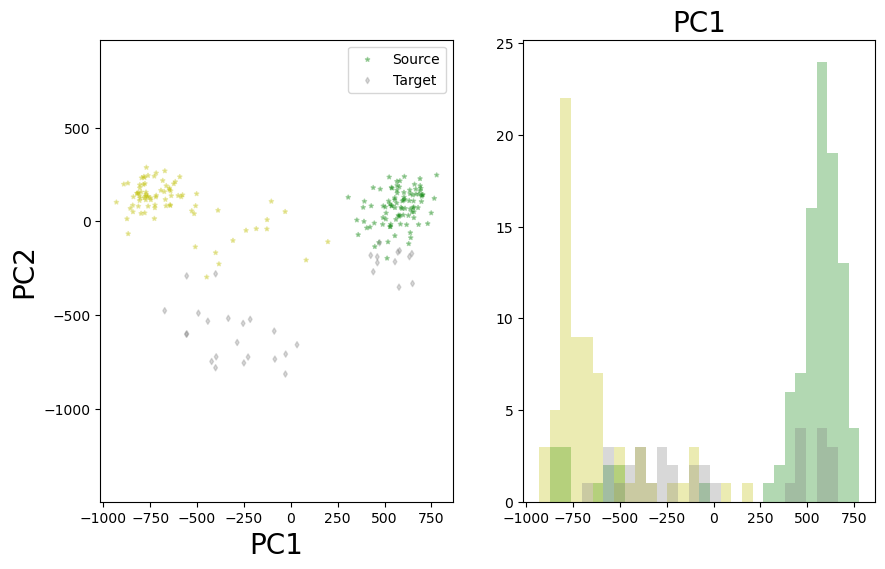

In [3]:
sub_idx = np.where((label == 1) | (label == 2))
PCA_plot(data[sub_idx],label[sub_idx],sample_domain[sub_idx],1,[1,2])

In [4]:
# Generate random data
np.random.seed(0)
a = ot.utils.unif(n1)  # weights of points in the source domain
b = ot.utils.unif(n2)  # weights of points in the target domain

x1 = data[sample_domain == 1]

x2 = data[sample_domain == -1]

# Compute the cost matrix
C = ot.dist(x1, x2)  # Squared Euclidean cost matrix by default

print(C)

[[ 906910.  1047668.  1124073.8 ... 1848770.5 2091487.8 1689113. ]
 [1089409.  1066678.2 1339816.8 ... 1994903.5 2228700.8 1875551.8]
 [1280738.5 1406162.5 1398295.  ... 2251730.2 2251743.  1924487.5]
 ...
 [1905090.5 1745327.5 2245904.  ...  808350.5 1397522.2 1330631.5]
 [1482530.  1252772.4 1953644.5 ... 1462189.4 1968765.2 1469978.8]
 [2653244.5 2493492.8 2456337.  ... 2258585.2 2656447.  2390664.5]]


## 三、exact OP 求解

### 3.1、求解样本间的OT问题

`ot.solve_sample()`函数用以求解两个样本集合之间的OT问题。前两个参数为源域和目标域样本，返回`ot.utils.OTResult`对象
- `value`:OT问题的loss，为OT计划与基础代价的元素对应乘积
- `plan`:OT计划矩阵
- `potential`:OT问题的对偶

In [5]:
# Solve the OT problem
sol = ot.solve_sample(x1, x2, a, b)

# get the OT plan
P = sol.plan

# get the OT loss
loss = sol.value

# get the dual potentials
alpha, beta = sol.potentials

print(f"OT loss = {loss:1.3f}")

OT loss = 1086625.461


<Axes: >

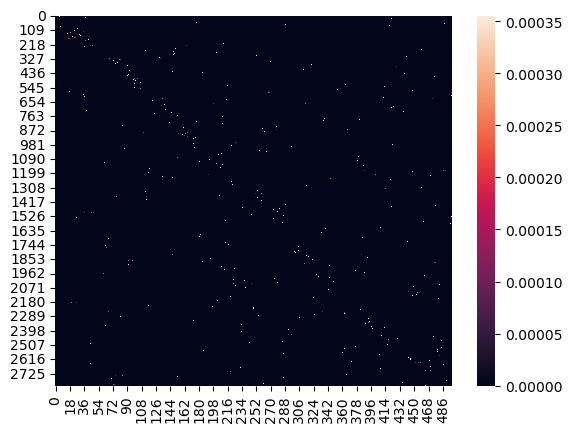

In [6]:
sns.heatmap(P)

### 3.2、指定代价矩阵的OT问题

代价矩阵可以通过传递到更泛化的函数`ot.solve()`来实现客制化，也可通过在`ot.solve_sample()`函数中传递`metric='cityblock'`作为参数实现。代价矩阵的大小为$(n_1,n_2)$，可通过`ot.dist()`计算两个样本集合之间的配对距离

In [ ]:
# Compute the cost matrix
C_city = ot.dist(x1, x2, metric="cityblock")

# Solve the OT problem with the custom cost matrix
sol = ot.solve(C_city)
# the parameters a and b are not provided so uniform weights are assumed
P_city = sol.plan
# on empirical data the same can be done with ot.solve_sample :
# sol = ot.solve_sample(x1, x2, metric='cityblock')

# Compute the OT loss (equivalent to ot.solve(C).value)
loss_city = sol.value  # same as np.sum(P_city * C)

print(f"OT loss = {loss_city:1.3f}")

In [ ]:
sns.heatmap(P_city)

## 四、Sinkhorn 与 Regularized OT
### 4.1、Sinkhorn 算法的Entropic OT
Sinkhorn算法求解Entropic Regularized OT问题。正则化强度由`reg`参数控制。Sinkhorn算法当正则化强度较大时计算快于 exact OT，但其解是exact OT的近似并且其OT计划不稀疏。

In [ ]:
# Solve the Sinkhorn problem (just add reg parameter value)
sol = ot.solve_sample(x1, x2, a, b, reg=1e-1)

# get the OT plan and loss
P_sink = sol.plan
loss_sink = sol.value  # objective value of the Sinkhorn problem (incl. entropy)
loss_sink_linear = sol.value_linear  # np.sum(P_sink * C) linear part of loss

print(f"OT loss = {loss_sink_linear:1.3f}")

In [ ]:
sns.heatmap(P_sink)

### 4.2、Quadratic Regularized OT

二次正则OT可以保持OT计划的稀疏性(较之于entropic OT而不是L1 正则OT)

In [ ]:
# use quadratic regularization
P_quad = ot.solve_sample(x1, x2, a, b, reg=3, reg_type="L2").plan

loss_quad = ot.solve_sample(x1, x2, a, b, reg=3, reg_type="L2").value

print(f"OT loss = {loss_quad:1.3f}")

In [ ]:
sns.heatmap(P_quad)

### 4.3、求解使用用户自定义的正则项的正则化OT问题

In [ ]:
# Define a custom regularization function
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G


P_reg = ot.solve_sample(x1, x2, a, b, reg=3, reg_type=(f, df)).plan

loss_reg = ot.solve_sample(x1, x2, a, b, reg=3, reg_type=(f, df)).value

print(f"OT loss:{loss_reg:1.3f}")

In [ ]:
sns.heatmap(P_reg)

## 五、Unbalanced and Partial OT

### 5.1、Unbalanced OT

不平衡OT放松了边缘限制，使得源域和目标域的总权重可以不同。`ot.sovle_sample()`函数通过设置边缘惩罚参数`unbalanced`参数为一个正值来求解不平衡OT问题

In [ ]:
# Solve the unbalanced OT problem with KL penalization
P_unb_kl = ot.solve_sample(x1, x2, a, b, unbalanced=5e-2).plan

# Unbalanced with KL penalization ad KL regularization
P_unb_kl_reg = ot.solve_sample(
    x1, x2, a, b, unbalanced=5e-2, reg=1e-1
).plan  # also regularized

# Unbalanced with L2 penalization
P_unb_l2 = ot.solve_sample(x1, x2, a, b, unbalanced=7e1, unbalanced_type="L2").plan

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
sns.heatmap(P_unb_kl, ax=axes[0])
sns.heatmap(P_unb_kl_reg, ax=axes[1])
sns.heatmap(P_unb_l2, ax=axes[2])
axes[0].set_title("Unbalanced KL")
axes[1].set_title("Unbalanced KL + Reg")
axes[2].set_title("Unbalanced L2")
plt.tight_layout()
plt.show()

### 5.2 Patial OT

In [ ]:
# Solve the Unbalanced OT problem with TV penalization (equivalent)
P_part_pen = ot.solve_sample(x1, x2, a, b, unbalanced=3, unbalanced_type="TV").plan

# Solve the Partial OT problem with mass constraints (only classic API)
P_part_const = ot.partial.partial_wasserstein(a, b, C, m=0.5)  # 50% mass transported

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(P_part_pen, ax=axes[0])
sns.heatmap(P_part_const, ax=axes[1])
axes[0].set_title("P_part_pen")
axes[1].set_title("P_part_const")
plt.tight_layout()
plt.show()

## 六、大规模OT
讨论使用exact OT问题近似求解大规模OT问题的策略。
### 6.1、Large scale Sinkhorn

当具有大量点的样本时，可使用更具有内存效率的lazy版本的Sinkhorn算法，以避免计算$n\times m$代价矩阵。

POT提供lazy Sinkhorn算法的两个应用，以lazy类型`ot.utils.LazyTensor`返回

In [ ]:
for a,b in zip(x1,x2):
    print (a,b)
    break